In [68]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..')
from models import LocationScaleFlow, SoftmaxWeight, SoftmaxWeightOver,DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

ImportError: cannot import name 'SoftmaxWeightOver' from 'models' (..\models\__init__.py)

In [ ]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(grey)

<ipython-input-69-2d72797f107c>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


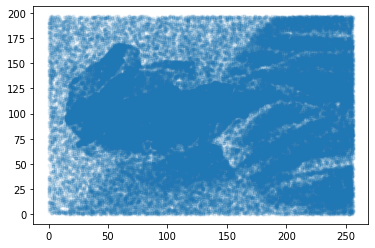

In [69]:
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])
'''target_samples[:,1] = target_samples[:,1]/torch.max(target_samples[:,1])
target_samples[:,0] = target_samples[:,0]/torch.max(target_samples[:,0])'''
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

<AxesSubplot:xlabel='x', ylabel='y'>

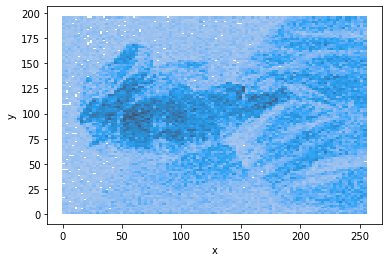

In [70]:
import seaborn as sns 
import pandas as pd
data_x = pd.DataFrame(target_samples[:,0])
data_x['label'] = 'x'
data_y = pd.DataFrame(target_samples[:,1])
data_y['label'] = 'y'
data = pd.DataFrame()
data['x'] = target_samples[:,0]
data['y'] = target_samples[:,1]
sns.histplot(data, x='x', y='y', bins = (100,100))

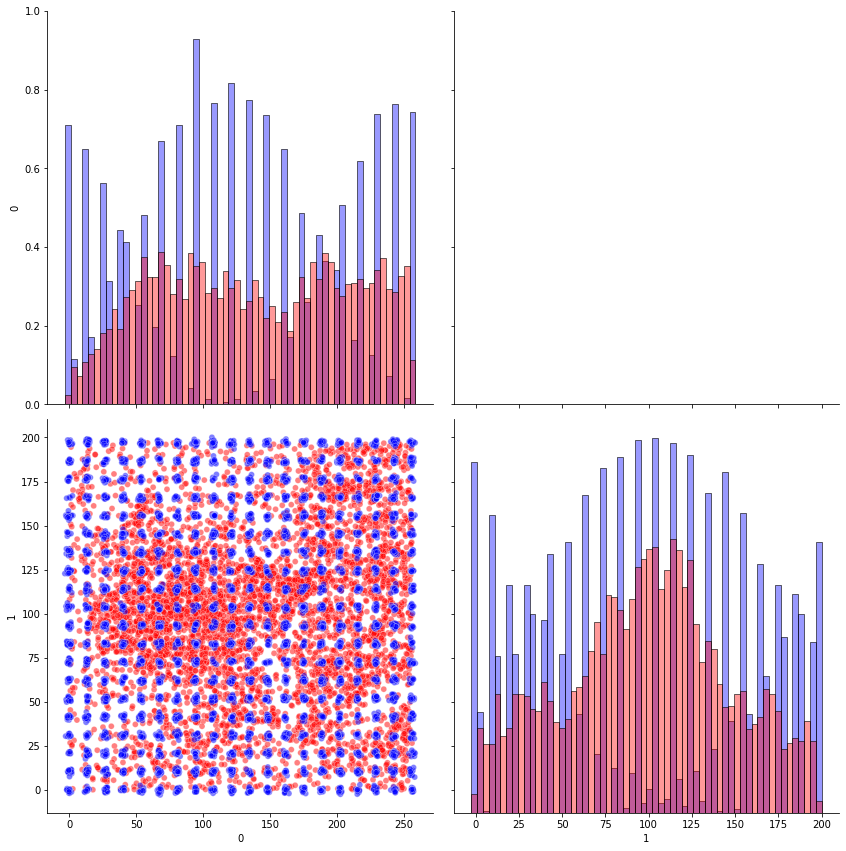

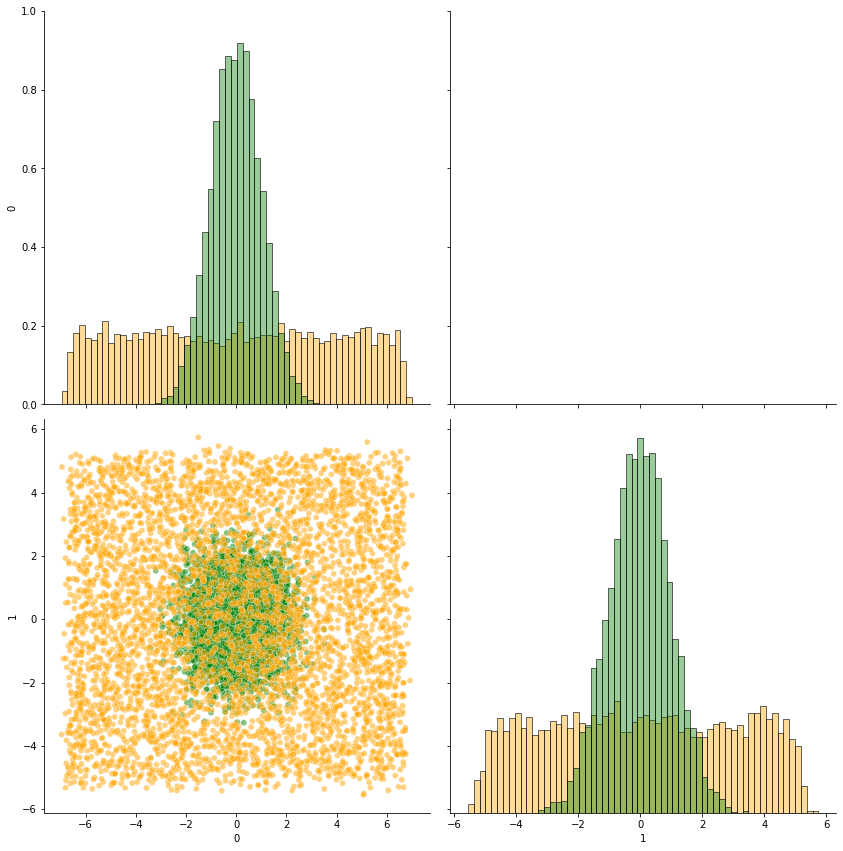

In [78]:
num_samples = target_samples.shape[0]
K = 400
initial_m = torch.cartesian_prod(torch.linspace(0, lignes,20),torch.linspace(0, colonnes, 20))
initial_L = torch.eye(2).unsqueeze(0).repeat(K, 1, 1)
initial_T = LocationScaleFlow(K, 2, initial_m = initial_m,initial_log_s= initial_L, mode = 'full_rank')
EM = EMDensityEstimator(target_samples,K, initial_T = initial_T)
#loss_values = EM.train(epochs,visual=True)
EM.model_visual()

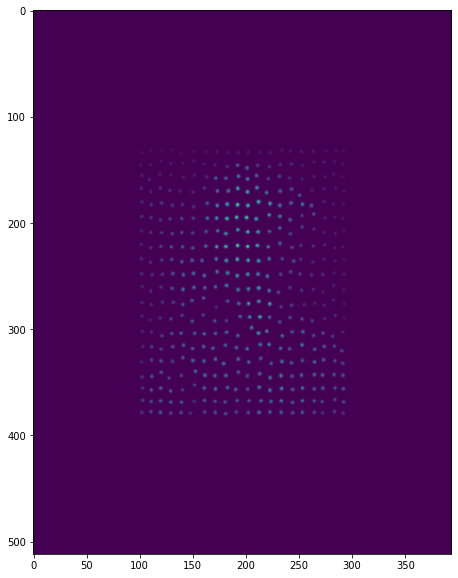

In [76]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-1/2*lignes, 1.5*lignes,2*lignes),torch.linspace(-1/2*colonnes,1.5*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [15]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 50000
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, 2, [], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 2))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
dif = DIFDensityEstimator(target_samples,K)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

  0%|                                                                                                                                                             | 0/100 [00:55<?, ?it/s]


KeyboardInterrupt: 

In [14]:
print(dif.w.log_prob(target_samples))

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SubBackward0>)


In [ ]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,2*lignes),torch.linspace(-colonnes/8, 1.125*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))